<a href="https://colab.research.google.com/github/caangonz/FPCUP_WGA/blob/main/Day3_Classification_RF_SVM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

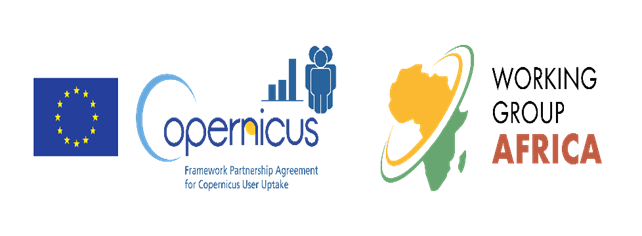

# **Day 3: Supervised machine learning classifier for Earth Observation data**

Carlos Gonzales-Inca
Department of Geography and Geology, University of Turku, Finland
email: cagoin@utu.fi

# Introduction

In supervised machine learning (ML) classification, algorithms learn from labeled or training data, representing a land cover type or unit to be classified. After understanding the data features, the algorithm predicts the pixel class and assigns their corresponding labels across the entire satellite image. GEE has several methods for image classification. A powerful and simple algorithms for supervised image classification are Random Forest (RF) and Support Vector machines (SVM).

**Learning objectives:**
- Introduction to basic steps of supervised machine learning images classifications
- Explorer how the ML methods harness spectral information from EO data
- Perform RF and SVM classifier in GEE and Colab-Python

# Start Earth Engine

In [ ]:
# Import Earth Engine
import ee

In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize()

In [ ]:
# Import your cloud free image mosaic of your study area
my_img = ee.Image('projects/tanz-lc-1572859339356/assets/s2_mask3_mo') # Replace with your image ID address from EE assest

In [ ]:
my_img

In [ ]:
# For interactive visualization, use geemap package
#!pip install geemap

In [ ]:
import geemap

In [ ]:
# Get your study area polygon
# Define a study area polygon, e.g., get coordinates from geojson.io
AOI = ee.Geometry.Polygon([
          [
            [
              39.12458705126903,
              -5.715564275365551
            ],
            [
              39.12458705126903,
              -6.494802946383345
            ],
            [
              39.61284944895485,
              -6.494802946383345
            ],
            [
              39.61284944895485,
              -5.715564275365551
            ],
            [
              39.12458705126903,
              -5.715564275365551
            ]
          ]
        ])

In [ ]:
AOI.getInfo()['coordinates']

In [ ]:
poi = AOI.centroid() # get the centroid coordinate of the study area
poi

In [ ]:
# Make map visualization
map = geemap.Map(center=[-6.11, 39.37],zoom=8)
url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}' # Add google satellite image
map.add_tile_layer(url, name='Google Satellite', attribution='Google')
map.addLayer(my_img, {'bands': ['b11', 'b8', 'b2'], 'min': 0, 'max': 0.5}, "My img"); #??
map.addLayerControl();
map

# Prepare Training Data for Land Cover Classes

In [ ]:
# Get the ESA Land use land cover data and use it for generating LU samples
lc = ee.Image('ESA/WorldCover/v100/2020').clip(AOI) #ESA WorldCover land cover

In [ ]:
lc

In [ ]:
lc_color = {'palettte':[
    '#006400', # 10 Tree cover
    '#ffbb22', # 20 Shrubland
    '#ffff4c', # 30 Grassland
    '#f096ff', # 40 Cropland
    '#fa0000', # 50 Built-up
    '#b4b4b4', # 60 Bare / Sparse vegetation
    '#f0f0f0', # 70 Snow and Ice
    '#0064c8', # 80 Water bodies
    '#0096a0', # 90 Herbaceous wetland
    '#00cf75', # 95 Mangroves
    '#fae6a0' # 100 Moss and lichen
    ], min:10,max:100}

In [ ]:
# Display the ESA lc data
map.addLayer(lc,lc_color,'ESA land use')
map

In [ ]:
# Create stratified sampling points of LU
stratified_sample = lc.stratifiedSample(
    numPoints=1000,  # Adjust the number of sample points as needed
    classBand="Map",  # Replace with the name of your land cover band
    region=AOI,
    scale=10,
    geometries=True
)

In [ ]:
# Extract saltellite bands value to the sampling points
stratified_sample_bands = my_img.sampleRegions(collection=stratified_sample, properties=["Map"], scale=10, geometries=True);

In [ ]:
stratified_sample_bands

In [ ]:
stratified_sample.first().getInfo()

In [ ]:
# Connect to your google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Export to your Google drive the samples, to plot spectral profile and spectral separability evaluation

task = ee.batch.Export.table.toDrive(
  collection = stratified_sample_bands2,
  description = 'my_LU_samples2',
  fileFormat= 'CSV'
  );
task.start()

# Evaluate your Training Data Spectral Separability

In [ ]:
# Read the image sample table
import pandas as pd
samples = pd.read_csv('/content/gdrive/MyDrive/Colab_My_Output/my_LU_samples.csv')

In [ ]:
samples

In [ ]:
samples.describe()

In [ ]:
list(samples.columns)

In [ ]:
summ = samples[['b1','b2','b3','b4','b5','b6','b8','b9','b10','b11','b12']].groupby(samples['Map'].astype(str)).median()

In [ ]:
summ

In [ ]:
list(summ.columns)

In [ ]:
summ = summ.reset_index()

In [ ]:
summ

,Map,b1,b2,b3,b4,b5,b6,b8,b9,b10,b11,b12
0,10,0.043525,0.043325,0.068575,0.050275,0.113275,0.253300,0.303325,0.332100,0.329850,0.202025,0.108325
1,20,0.045900,0.048500,0.075500,0.060525,0.125300,0.251025,0.298400,0.328925,0.325550,0.233600,0.130350
2,30,0.056125,0.062125,0.088625,0.087850,0.142550,0.251950,0.292700,0.321925,0.317700,0.284425,0.181250
3,40,0.066750,0.072200,0.097175,0.109175,0.158050,0.240850,0.274275,0.300625,0.300100,0.306175,0.224600
4,50,0.099700,0.110275,0.127350,0.141450,0.169400,0.223225,0.237600,0.256350,0.264250,0.255600,0.209000
5,60,0.070150,0.082250,0.107600,0.119975,0.166900,0.261025,0.307525,0.334237,0.328250,0.272425,0.193975
6,80,0.070550,0.066450,0.057700,0.049450,0.052800,0.049100,0.044900,0.047750,0.052500,0.044200,0.040100
7,90,0.081650,0.097950,0.126550,0.115275,0.168300,0.217250,0.235500,0.255650,0.256325,0.179000,0.101000
8,95,0.034650,0.034000,0.055650,0.038750,0.096100,0.221500,0.268575,0.295650,0.286650,0.104350,0.052775


In [ ]:
melted_df = pd.melt(
    summ,
    id_vars=['Map'],
    value_vars=['b1','b2','b3','b4','b5','b6','b8','b9','b10','b11','b12'],
    var_name='bands',
    value_name='refl'
)

In [ ]:
melted_df

,Map,bands,refl
0,10,b1,0.043525
1,20,b1,0.045900
2,30,b1,0.056125
3,40,b1,0.066750
4,50,b1,0.099700
...,...,...,...
94,50,b12,0.209000
95,60,b12,0.193975
96,80,b12,0.040100
97,90,b12,0.101000


In [ ]:
import seaborn as sns

<Axes: xlabel='bands', ylabel='refl'>

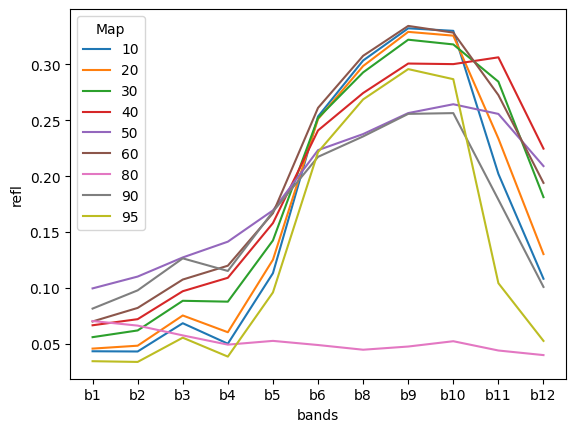

In [ ]:
sns.lineplot(data=melted_df, x="bands", y="refl", hue="Map")

In [ ]:
  """
    '#006400', # 10 Tree cover
    '#ffbb22', # 20 Shrubland
    '#ffff4c', # 30 Grassland
    '#f096ff', # 40 Cropland
    '#fa0000', # 50 Built-up
    '#b4b4b4', # 60 Bare / Sparse vegetation
    '#f0f0f0', # 70 Snow and Ice
    '#0064c8', # 80 Water bodies
    '#0096a0', # 90 Herbaceous wetland
    '#00cf75', # 95 Mangroves
    '#fae6a0' # 100 Moss and lichen

In [ ]:
# If needed, merge LC classes, e.g, Tree cover (10) with Shrubland (20)
"""
old_values = [10,20,30,40,50,60,70,80,90,95,100]
new_values = [20,20,30,40,50,60,70,80,90,95,100]
stratified_sample2 =stratified_sample.remap(old_values,new_values,'Map')
stratified_sample2.first().getInfo()

# Split your Samples into training and validation dataset

In [ ]:
# Split the sample poinst into train and vilidation data
# Firts, add a column with random values from 0 to 1 to split the dataset
stratified_sample_bands = stratified_sample_bands.randomColumn(seed=0)

train = stratified_sample_bands.filter(ee.Filter.lt('random',0.7)) # use 70% of the data for training
validation = stratified_sample_bands.filter(ee.Filter.gte('random',0.7)) # use 30% of the data for validation

In [ ]:
map.addLayer(train.draw('red'),{}, 'Training samples')
map.addLayer(validation.draw('yellow'),{}, 'Validation samples')
map

# Train a Radon Forest Classifier Model

In [ ]:
# Train a Random forest classifier model for classification prediction

rf_params = {"numberOfTrees":300, # the number of individual decision tree models
              "variablesPerSplit":None,  # the number of variable to use per split, default sqr of the nro of variables
              "minLeafPopulation":1, # smallest sample size possible per leaf
              "bagFraction":0.7, # fraction of data to include for each individual tree model
              "maxNodes":None, # max number of leafs/nodes per tree, default is unlimited
               "seed":0}  # random seed for "random" choices like sampling. Setting this allows others to reproduce your exact results even with stocastic parameters

In [ ]:
RF_model = ee.Classifier.smileRandomForest(**rf_params).train(
  features = train,
  classProperty = 'Map',
  inputProperties= my_img.bandNames()
)

In [ ]:
RF_model

In [ ]:
# Use the RF model to perform image classification
RF_lc_classified = my_img.classify(RF_model)
RF_lc_classified

In [ ]:
map.addLayer(RF_lc_classified.randomVisualizer(),{},"Random forest LC classification")
map

In [ ]:
# Estimate area by land cover class (m^2)
Area_img = ee.Image.pixelArea().addBands(
      RF_lc_classified)

In [ ]:
Area_img

In [ ]:
Class_areas = areaImage.reduceRegion(**{
      'reducer': ee.Reducer.sum().group(**{
      'groupField': 1,
      'groupName': 'classification',
    }),
    'geometry': AOI,
    'scale': 20,
    'maxPixels': 1e10
    });

In [ ]:
Class_areas

# RF Classification Accuracy Evaluation

In [ ]:
# Random forest evaluation
# Extract classified image data values to validation points
validation_RF = RF_lc_classified.sampleRegions(
  collection = validation, # your validation data
  properties = ['Map'], # field of your classes
  scale = 10,
  )

In [ ]:
validation_RF

In [ ]:
# Compare the landcover of your validation data against the classification output

testAccuracy_RF = validation_RF.errorMatrix('Map', 'classification') #'classification' is the property of classified image
testAccuracy_RF

In [ ]:
# Calculate overall accuracy
testAccuracy_RF.accuracy()

In [ ]:
# Calculate user's accuracy or
# specificity and the complement of commission error (1 − commission error)
testAccuracy_RF.consumersAccuracy()

In [ ]:
# Calculate producer's accuracy, also known as sensitivity and the
# complement of omission error (1 − omission error).
testAccuracy_RF.producersAccuracy()

In [ ]:
# Calculate kappa statistic.
testAccuracy_RF.kappa()

In [ ]:
# EXPORT YOUR RF CLASSIFIED IMAGE

task = ee.batch.Export.image.toDrive(**{
    'image': RF_lc_classified,
    'description': 'RF_lc_classified',
    'folder':'Colab_My_Output',
    'scale': 20,
    'region': AOI.getInfo()['coordinates']
})
task.start()

# Train a Suport Vector Machine (SVM) Classifier Model

In [ ]:
# Create an SVM classifier with custom parameters.

svm_par = {
  'svmType': 'C_SVC', # Default = C_SVC, NU_SVC, ONE_CLASS
  'kernelType': 'LINEAR', # Default = LINEAR, POLY, RBF, or SIGMOID
  #degree: 2, # Valid for POLY kernels
  #gamma: 0.5, # Valid for POLY, RBF and SIGMOID kernels
  'cost': 5 # Only valid for C-SVC
  };

In [ ]:
SVM_model = ee.Classifier.libsvm(**svm_par).train(
        features = train,
        classProperty = 'Map',
        inputProperties= my_img.bandNames()
        )

In [ ]:
# Classify the image with classifier_svm.
SVM_lc_classified = my_img.classify(SVM_model)
SVM_lc_classified

In [ ]:
# Display the SVM classified image
map.addLayer(SVM_lc_classified.randomVisualizer(), {}, 'SVM lc classfied')
map

# SVM Classification Accuracy Assessment

In [ ]:
# REPEAT CLASSIFICATION ACCURACY ASSESSMENT